<a href="https://colab.research.google.com/github/Jorgellamocca/Cambio-Clim-tico/blob/main/cmip6_mensual_lectura_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# INSTALACIÓN + IMPORTS
# ============================================================
!pip install -q intake intake-esm xarray netcdf4 zarr cartopy shapely pyproj fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp

import intake
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["figure.dpi"] = 120

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 4.5 M

In [2]:
# ============================================================
# DEFINIR DOMINIO
# ============================================================

# Dominio común "Piura ampliado" (como tu ejemplo)
#DOMINIO = dict(
#    lat=slice(-8.5, -2.2),
#    lon=slice(-81.5, -77.5)
#)

# Dominio común "Ayacucho" (como tu ejemplo)
#DOMINIO = dict(
#    lat=slice(-15.5, -11.5),
#    lon=slice(-76.5, -69.5)
#)

# Dominio común "Region Sur" (como tu ejemplo)
DOMINIO = dict(
    lat=slice(-18.8, -13.0),
    lon=slice(-77.5, -68.5)
)

In [3]:
#DEFINIR LAT Y LON PARA LA SERIE DE EJEMPLO (PUNTO DENTRO DEL DOMINIO)

# Punto para serie temporal (Cambiar para la region se trabajo)
#LAT_PTO = -6.0
#LON_PTO = -80.0

# Punto para serie temporal (Cambiar para la region se trabajo)
#LAT_PTO = -13.5
#LON_PTO = -71.9

# Punto para serie temporal (JULIACA - PUNO)
LAT_PTO = -15.5
LON_PTO = -70.1

# Fecha de ejemplo para mapas
FECHA_EJEMPLO = "1990-01"

# Periodo climatológico base
PERIODO_CLIM = slice("1981-01", "2010-12")

LAT_MIN = DOMINIO["lat"].start
LAT_MAX = DOMINIO["lat"].stop
LON_MIN = DOMINIO["lon"].start
LON_MAX = DOMINIO["lon"].stop

proj = ccrs.PlateCarree()

In [4]:
# ============================================================
# FUNCIONES ÚTILES (tas)
# ============================================================

def fix_lon_cmip(ds):
    """0–360 → -180–180 para CMIP6"""
    if "lon" in ds.coords:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        ).sortby("lon")
    return ds


def fix_lon_era(ds):
    """0–360 → -180–180 para ERA5 (longitude)"""
    if "longitude" in ds.coords:
        ds = ds.assign_coords(
            longitude=((ds.longitude + 180) % 360) - 180
        ).sortby("longitude")
    return ds


def squeeze_cmip_da(da):
    """
    Quita dimensiones extra típicas de CMIP6 si existen
    (member_id, dcpp_init_year, etc.) tomando el índice 0.
    """
    for d in [
        "member_id",
        "dcpp_init_year",
        "variant_label",
        "realization",
        "init_year"
    ]:
        if d in da.dims:
            da = da.isel({d: 0})
    return da.squeeze()


def plot_map_tas(da2d, title, vmin=10, vmax=30):
    """
    Mapa simple de temperatura mensual (tas, °C).
    """

    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection=proj)
    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=proj)

    ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    im = ax.pcolormesh(
        da2d.lon,
        da2d.lat,
        da2d.values,
        cmap="RdYlBu_r",
        shading="auto",
        transform=proj,
        vmin=vmin,
        vmax=vmax
    )

    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Temperatura (°C)")

    ax.set_title(title, fontweight="bold")
    plt.tight_layout()
    plt.show()



Abriendo ACCESS-ESM1-5 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ ACCESS-ESM1-5 cargado
  dims plot: ('lat', 'lon'), shape=(5, 5)


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


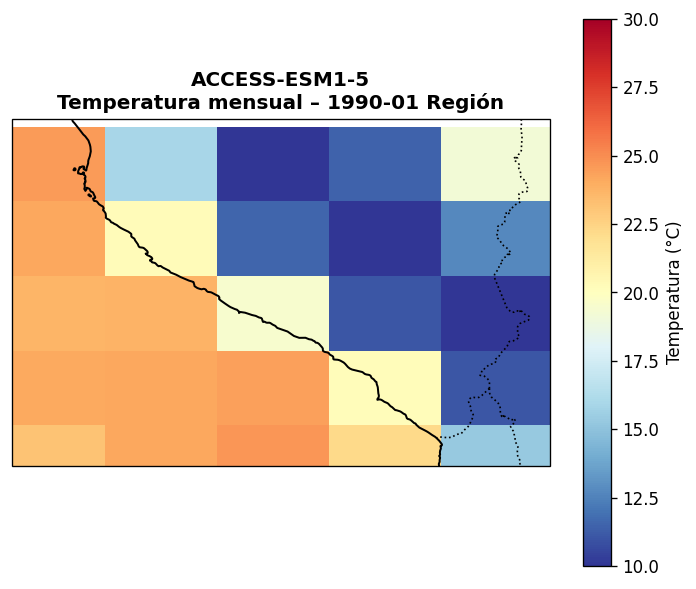


Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado
  dims plot: ('lat', 'lon'), shape=(6, 8)


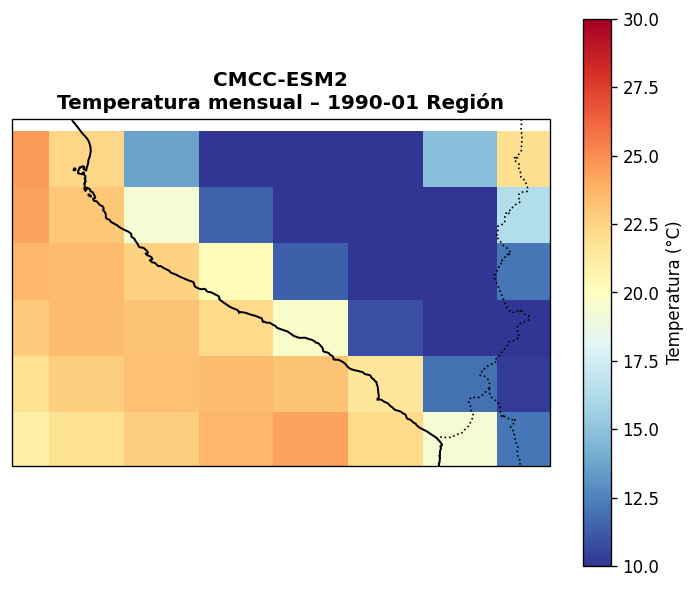


Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado
  dims plot: ('lat', 'lon'), shape=(4, 7)


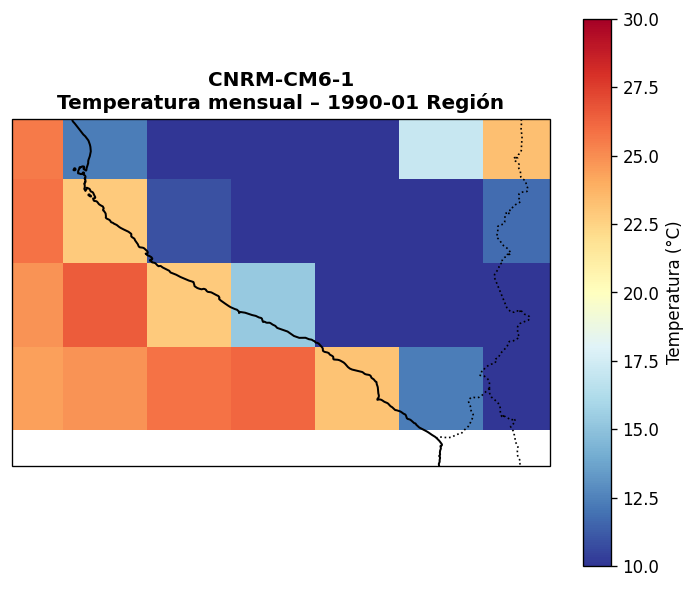


Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado
  dims plot: ('lat', 'lon'), shape=(5, 8)


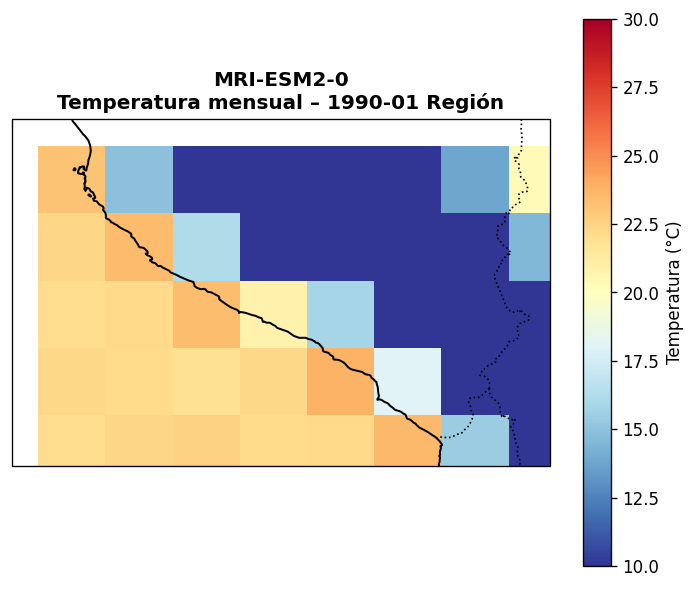


Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado
  dims plot: ('lat', 'lon'), shape=(6, 8)


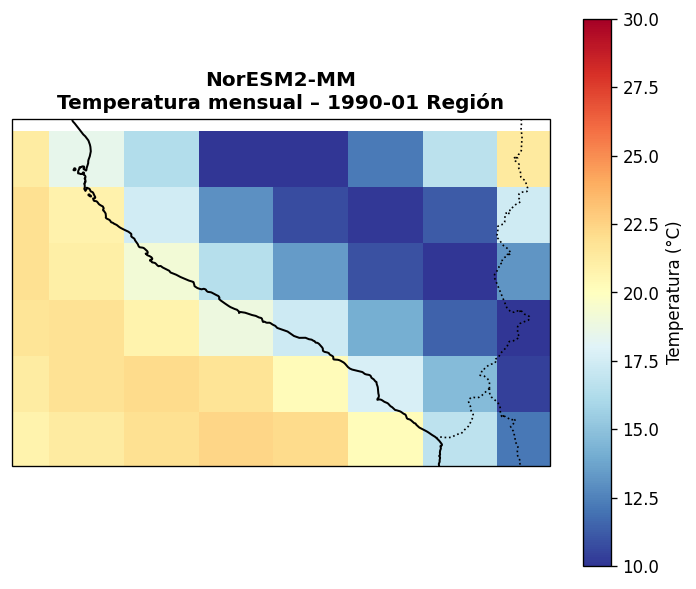

In [5]:
# ============================================================
# LEER 5 MODELOS CMIP6 MENSUAL (tas), PARTE HISTÓRICA
# ============================================================

cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)

MODELOS = {
    "ACCESS-ESM1-5": "r1i1p1f1",
    "CMCC-ESM2":     "r1i1p1f1",
    "CNRM-CM6-1":    "r1i1p1f2",
    "MRI-ESM2-0":    "r1i1p1f1",
    "NorESM2-MM":    "r1i1p1f1"
}

datasets = {}
tas_por_modelo = {}   # aquí guardaremos tas mensual (°C) por modelo

for modelo, member in MODELOS.items():
    print(f"\nAbriendo {modelo} ({member})...")

    cat_tmp = cat.search(
        activity_id="CMIP",
        source_id=modelo,
        experiment_id="historical",
        table_id="Amon",
        variable_id="tas",   # 👈 CAMBIO CLAVE
        member_id=member
    )

    if len(cat_tmp.df) == 0:
        print(f"  ❌ {modelo}: no disponible en este filtro")
        continue

    ds_dict = cat_tmp.to_dataset_dict(
        zarr_kwargs={"consolidated": False},
        storage_options={"token": "anon"},
        xarray_open_kwargs={"use_cftime": True}
    )

    ds = list(ds_dict.values())[0]
    ds = fix_lon_cmip(ds)
    datasets[modelo] = ds
    print(f"  ✅ {modelo} cargado")

    # ---- tas mensual en °C ----
    tas_modelo = ds["tas"] - 273.15
    tas_modelo.attrs["units"] = "°C"
    tas_modelo.attrs["long_name"] = "Temperatura del aire a 2 m"

    tas_por_modelo[modelo] = tas_modelo

    # ---- mapa ejemplo ----
    tas_area = tas_modelo.sel(**DOMINIO)
    tas_plot = tas_area.sel(time=FECHA_EJEMPLO)
    tas_plot = squeeze_cmip_da(tas_plot)

    # verificación dims
    print(f"  dims plot: {tas_plot.dims}, shape={tas_plot.shape}")

    plot_map_tas(
        tas_plot,
        title=f"{modelo}\nTemperatura mensual – {FECHA_EJEMPLO} Región"
    )


In [6]:
#LEER ERA5

In [7]:
!pip install -q xarray zarr fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp > /dev/null 2>&1
!apt-get install -qq -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install -q cartopy shapely pyproj > /dev/null 2>&1

In [11]:

import xarray as xr
xr.backends.list_engines()

{'netcdf4': <NetCDF4BackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html,
 'h5netcdf': <H5netcdfBackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html,
 'scipy': <ScipyBackendEntrypoint>
   Open netCDF files (.nc, .cdf and .nc.gz) using scipy in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html,
 'kerchunk': <KerchunkBackend>
   Open Kerchunk References with Xarray
   Learn more at https://fsspec.github.io/kerchunk/,
 'pydap': <PydapBackendEntrypoint>
   Open remote datasets via OPeNDAP using pydap in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.PydapBackendEntrypoint.html,
 'store': <S

In [12]:
#Usar token registrado
TOKEN = "edh_pat_fcb2e9f52c35ff7fd7cc2f2d14317393c9e299c8c1c1f81a94216161433a0943f554036a62b849c1af67f0c0400c31e3"

# Crear el archivo
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Permisos
!chmod 600 /root/.netrc


Abriendo ERA5 mensual (t2m)...
ERA5 area shape: (1031, 24, 37)


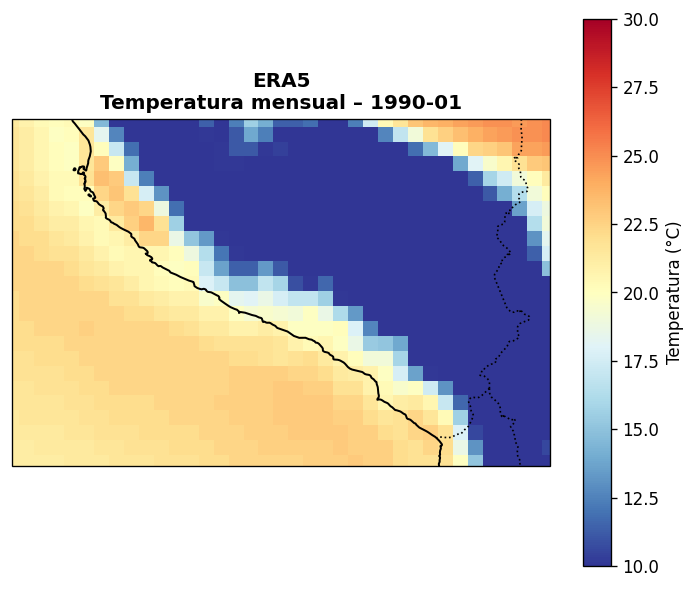

In [13]:
# ============================================================
# 3) ERA5 – LECTURA HISTÓRICA (TEMPERATURA t2m)
# ============================================================
print("\nAbriendo ERA5 mensual (t2m)...")

era = xr.open_dataset(
    "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr",
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# Corregir longitudes
era = fix_lon_era(era)

# Ordenar coordenadas
era = era.sortby("latitude")
era = era.sortby("longitude")

# ------------------------------------------------------------
# Temperatura ERA5 en °C
# ------------------------------------------------------------
tas_era5_all = era.t2m - 273.15
tas_era5_all.attrs["units"] = "°C"
tas_era5_all.attrs["long_name"] = "Temperatura del aire a 2 m (ERA5)"

# ------------------------------------------------------------
# Recorte espacial al dominio de estudio
# ------------------------------------------------------------
tas_era5_area = tas_era5_all.sel(
    latitude=slice(DOMINIO["lat"].start, DOMINIO["lat"].stop),
    longitude=slice(DOMINIO["lon"].start, DOMINIO["lon"].stop)
)

print("ERA5 area shape:", tas_era5_area.shape)

# ------------------------------------------------------------
# Mapa de ejemplo
# ------------------------------------------------------------
tas_era5_plot = (
    tas_era5_area
    .sel(valid_time=FECHA_EJEMPLO)
    .squeeze()
    .rename({"latitude": "lat", "longitude": "lon"})
)

plot_map_tas(
    tas_era5_plot,
    f"ERA5\nTemperatura mensual – {FECHA_EJEMPLO}"
)


Meses comunes: 360
Inicio: 198101 Fin: 201012


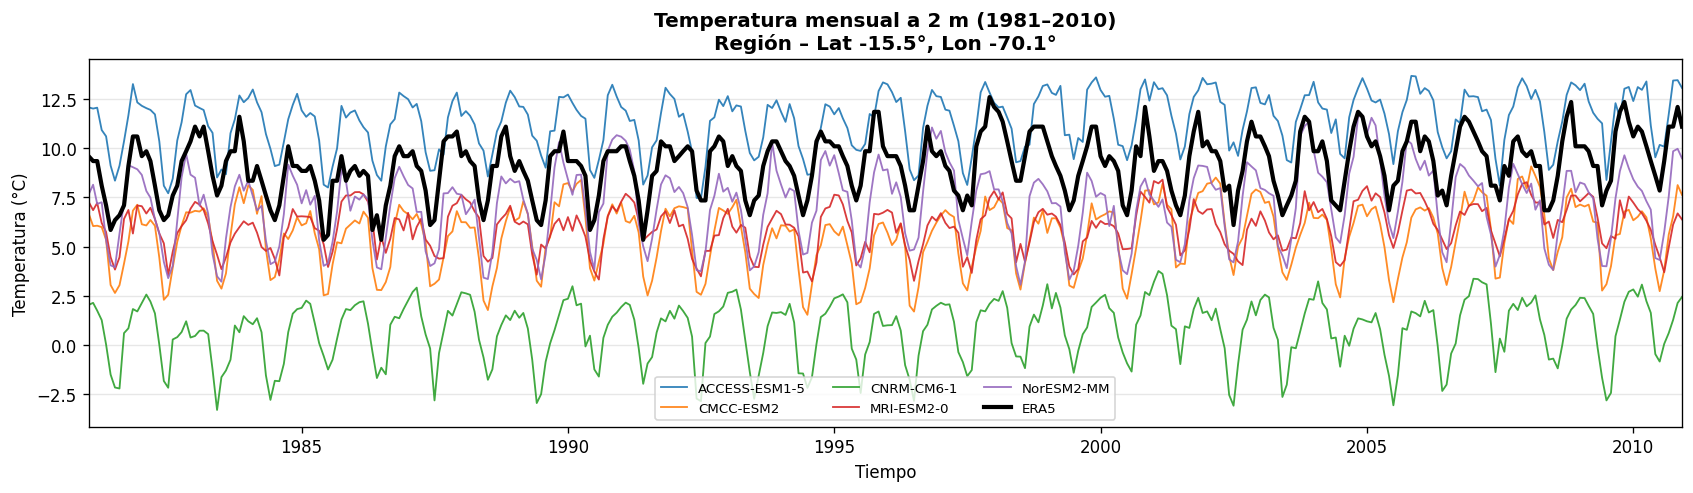

In [14]:
# ============================================================
# SERIE COMPLETA 1981–2010 EN (LAT=-6, LON=-80)
# COMPARAR 5 MODELOS CMIP6 (tas) vs ERA5 (t2m)
# ============================================================

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# ERA5: SERIE TEMPORAL EN EL PUNTO
# ------------------------------------------------------------
tas_era5_point = (
    tas_era5_all
    .sel(valid_time=PERIODO_CLIM)
    .sel(latitude=LAT_PTO, longitude=LON_PTO, method="nearest")
    .rename(valid_time="time")
    .squeeze()
)

# Clave mensual YYYYMM (datetime64)
era_ym = (tas_era5_point.time.dt.year * 100 +
          tas_era5_point.time.dt.month).astype(int)

tas_era5_point = (
    tas_era5_point
    .assign_coords(ym=("time", era_ym.values))
    .swap_dims({"time": "ym"})
    .drop_vars("time")
)


# ------------------------------------------------------------
# CMIP6: SERIES TEMPORALES EN EL PUNTO
# ------------------------------------------------------------
series_cmip = {}

for modelo, tas in tas_por_modelo.items():

    s = (
        tas.sel(time=PERIODO_CLIM)
           .sel(lat=LAT_PTO, lon=LON_PTO, method="nearest")
    )

    s = squeeze_cmip_da(s)

    # Clave mensual YYYYMM (cftime compatible)
    cmip_ym = (s.time.dt.year * 100 +
               s.time.dt.month).astype(int)

    s = (
        s.assign_coords(ym=("time", cmip_ym.values))
         .swap_dims({"time": "ym"})
         .drop_vars("time")
    )

    series_cmip[modelo] = s


# ------------------------------------------------------------
# INTERSECCIÓN COMÚN DE MESES
# ------------------------------------------------------------
common_ym = set(tas_era5_point.ym.values.tolist())

for s in series_cmip.values():
    common_ym = common_ym.intersection(set(s.ym.values.tolist()))

common_ym = np.array(sorted(common_ym))

print("Meses comunes:", len(common_ym))
print("Inicio:", common_ym[0], "Fin:", common_ym[-1])


# ------------------------------------------------------------
# RECORTE FINAL
# ------------------------------------------------------------
tas_era5_aligned = tas_era5_point.sel(ym=common_ym)
series_cmip_aligned = {
    m: s.sel(ym=common_ym) for m, s in series_cmip.items()
}


# ------------------------------------------------------------
# GRÁFICO FINAL (PRESENTACIÓN MEJORADA)
# ------------------------------------------------------------

# Eje temporal bonito
time_plot = pd.to_datetime(common_ym.astype(str), format="%Y%m")

plt.figure(figsize=(14, 4), constrained_layout=True)

# Modelos CMIP6
for modelo, serie in series_cmip_aligned.items():
    plt.plot(
        time_plot,
        serie.values,
        lw=1.1,
        alpha=0.9,
        label=modelo
    )

# ERA5 destacado
plt.plot(
    time_plot,
    tas_era5_aligned.values,
    color="black",
    lw=2.5,
    label="ERA5",
    zorder=5
)

# Título
plt.title(
    f"Temperatura mensual a 2 m (1981–2010)\n"
    f"Región – Lat {LAT_PTO}°, Lon {LON_PTO}°",
    fontweight="bold"
)

plt.xlabel("Tiempo")
plt.ylabel("Temperatura (°C)")

plt.margins(x=0)
plt.xlim(time_plot[0], time_plot[-1])

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))  # cada 5 años
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Grid solo horizontal
ax.grid(axis="y", alpha=0.3)
ax.grid(axis="x", alpha=0)

plt.legend(ncol=3, fontsize=8)
plt.show()


In [15]:
# ============================================================
# 4) LINEAR SCALING (LS) ESPACIAL POR MES: CMIP6 -> ERA5
#     Periodo base: 1981-01 a 2010-12
#     Variable: tas (°C)
#     Resultado: FACTORES y PR_CORR en memoria
# ============================================================

import numpy as np
import xarray as xr
import pandas as pd

PERIODO_CLIM = slice("1981-01", "2010-12")

# ------------------------------------------------------------
# 4.1 Dominio con BUFFER (mejora visualización)
# ------------------------------------------------------------
def expand_domain(dominio, dlat=2.0, dlon=2.0):
    return dict(
        lat=slice(dominio["lat"].start - dlat,
                  dominio["lat"].stop  + dlat),
        lon=slice(dominio["lon"].start - dlon,
                  dominio["lon"].stop  + dlon),
    )

DOMINIO_BUF = expand_domain(DOMINIO, dlat=2.0, dlon=2.0)

In [16]:
# ------------------------------------------------------------
# 4.2 ERA5: dominio + periodo + grilla objetivo (tas)
# ------------------------------------------------------------

era_domain = dict(
    latitude=slice(DOMINIO_BUF["lat"].start, DOMINIO_BUF["lat"].stop),
    longitude=slice(DOMINIO_BUF["lon"].start, DOMINIO_BUF["lon"].stop),
)

tas_era5_dom = (
    tas_era5_all
    .sel(valid_time=PERIODO_CLIM)
    .sel(**era_domain)
    .sortby("latitude")
    .sortby("longitude")
)

# Grilla objetivo ERA5
era_lat = tas_era5_dom.latitude
era_lon = tas_era5_dom.longitude

# ------------------------------------------------------------
# Climatología ERA5 mensual (12 meses)
# ------------------------------------------------------------
clim_era5 = (
    tas_era5_dom
    .groupby("valid_time.month")
    .mean("valid_time", skipna=True)
)

clim_era5.name = "tas_clim_era5"
clim_era5.attrs["units"] = "°C"
clim_era5.attrs["long_name"] = "Climatología mensual ERA5 T2M (1981–2010)"

print("ERA5 listo | climatología:", clim_era5.shape)


ERA5 listo | climatología: (12, 40, 53)


In [17]:
# ------------------------------------------------------------
# 4.3 Funciones (tas)
# ------------------------------------------------------------

def cmip_to_era_grid_tas(tas_cmip_c, era_lat, era_lon, dominio, periodo):
    """
    Interpola CMIP6 tas (time, lat, lon) directamente a la grilla ERA5.
    Devuelve DataArray con dims:
    (valid_time, latitude, longitude)
    """

    da = (
        tas_cmip_c
        .sel(time=periodo)
        .sel(**dominio)
    )

    # Quitar dimensiones extra CMIP6
    da = squeeze_cmip_da(da)

    # interp requiere coords monótonas
    da = da.sortby("lat").sortby("lon")

    # Interpolación bilinear (ERA5 define la grilla)
    da_i = da.interp(lat=era_lat, lon=era_lon, method="linear")

    # Renombrar tiempo
    da_i = da_i.rename({"time": "valid_time"})

    # Limpieza: eliminar coords heredadas CMIP6
    da_i = da_i.drop_vars(
        [c for c in da_i.coords
         if c not in {"valid_time", "latitude", "longitude"}],
        errors="ignore"
    )

    da_i.attrs["units"] = "°C"
    da_i.attrs["long_name"] = "Temperatura del aire a 2 m (CMIP6 → ERA5)"

    return da_i


def monthly_climatology(da):
    """Climatología mensual."""
    return da.groupby("valid_time.month").mean("valid_time", skipna=True)


def ls_factor_additive(clim_ref, clim_mod):
    """
    Linear Scaling aditivo (temperatura):
    factor = ERA5 − MODELO
    """
    factor = clim_ref - clim_mod
    factor.name = "ls_factor_tas"
    factor.attrs["units"] = "°C"
    return factor


In [18]:
# ------------------------------------------------------------
# 4.4 Cálculo LS por MODELO (tas)
# ------------------------------------------------------------

FACTORES_TAS = {}   # (month, latitude, longitude)
TAS_CORR     = {}   # (valid_time, latitude, longitude)

for modelo, tas_cmip in tas_por_modelo.items():
    print(f"\n--- Procesando {modelo} ---")

    # 1) CMIP → ERA5 grid (con buffer)
    tas_cmip_on_era = cmip_to_era_grid_tas(
        tas_cmip,
        era_lat,
        era_lon,
        DOMINIO_BUF,
        PERIODO_CLIM
    )

    # 2) Climatología mensual del modelo
    clim_mod = monthly_climatology(tas_cmip_on_era)

    # 3) Factor LS mensual espacial (ADITIVO)
    factor = ls_factor_additive(clim_era5, clim_mod)
    factor.attrs.update({
        "description": "Linear Scaling monthly spatial factor (ERA5 − MODEL)",
        "period_base": "1981-2010",
        "model": modelo,
        "variable": "tas"
    })
    FACTORES_TAS[modelo] = factor

    # 4) Aplicar corrección (SUMA, no multiplicación)
    tas_corr = tas_cmip_on_era.groupby("valid_time.month") + factor
    tas_corr = tas_corr.drop_vars("month", errors="ignore")
    tas_corr.name = "tas_ls"
    tas_corr.attrs.update({
        "units": "°C",
        "calibration": "Linear Scaling aditivo vs ERA5 (1981–2010)",
        "model": modelo
    })
    TAS_CORR[modelo] = tas_corr

    print("✔ Factor y serie corregida en memoria")

print("\n✔ LS TAS COMPLETADO")
print("Modelos en FACTORES_TAS:", list(FACTORES_TAS.keys()))
print("Modelos en TAS_CORR    :", list(TAS_CORR.keys()))



--- Procesando ACCESS-ESM1-5 ---
✔ Factor y serie corregida en memoria

--- Procesando CMCC-ESM2 ---
✔ Factor y serie corregida en memoria

--- Procesando CNRM-CM6-1 ---
✔ Factor y serie corregida en memoria

--- Procesando MRI-ESM2-0 ---
✔ Factor y serie corregida en memoria

--- Procesando NorESM2-MM ---
✔ Factor y serie corregida en memoria

✔ LS TAS COMPLETADO
Modelos en FACTORES_TAS: ['ACCESS-ESM1-5', 'CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM']
Modelos en TAS_CORR    : ['ACCESS-ESM1-5', 'CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM']


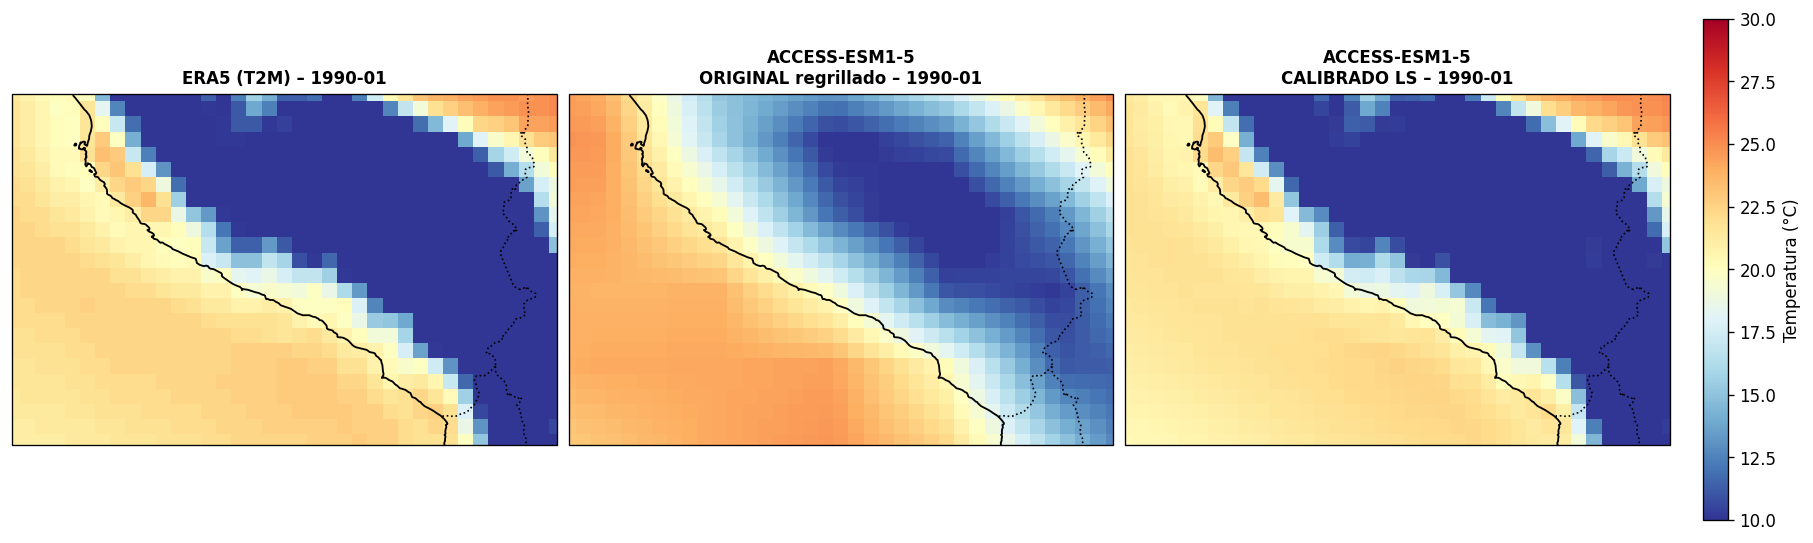

In [19]:
# ============================================================
# COMPARACIÓN PARA FECHA DE EJEMPLO: ERA5 | CMIP regrillado | CMIP calibrado (tas)
# ============================================================

modelo = "ACCESS-ESM1-5"
fecha  = FECHA_EJEMPLO

# ------------------------------------------------------------
# Datos
# ------------------------------------------------------------

# ERA5 (t2m)
era = (
    tas_era5_dom
    .sel(valid_time=fecha)
    .squeeze("valid_time")
    .rename({"latitude": "lat", "longitude": "lon"})
)

# CMIP6 ORIGINAL regrillado a ERA5
cmip_orig = (
    cmip_to_era_grid_tas(
        tas_por_modelo[modelo],
        era_lat, era_lon,
        DOMINIO_BUF, PERIODO_CLIM
    )
    .sel(valid_time=fecha)
    .squeeze("valid_time")
    .sel(
        latitude=slice(DOMINIO["lat"].start, DOMINIO["lat"].stop),
        longitude=slice(DOMINIO["lon"].start, DOMINIO["lon"].stop),
    )
    .rename({"latitude": "lat", "longitude": "lon"})
)

# CMIP6 CALIBRADO (LS aditivo)
cmip_corr = (
    TAS_CORR[modelo]
    .sel(valid_time=fecha)
    .squeeze("valid_time")
    .sel(
        latitude=slice(DOMINIO["lat"].start, DOMINIO["lat"].stop),
        longitude=slice(DOMINIO["lon"].start, DOMINIO["lon"].stop),
    )
    .rename({"latitude": "lat", "longitude": "lon"})
)

# ------------------------------------------------------------
# Parámetros comunes
# ------------------------------------------------------------

vmin, vmax = 10, 30   # ajusta si tu región lo requiere

extent = [
    DOMINIO["lon"].start, DOMINIO["lon"].stop,
    DOMINIO["lat"].start, DOMINIO["lat"].stop,
]

# ============================================================
# FIGURA 1x3
# ============================================================

fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(15, 5),
    subplot_kw={"projection": proj},
    constrained_layout=True
)

campos = [era, cmip_orig, cmip_corr]
titulos = [
    f"ERA5 (T2M) – {fecha}",
    f"{modelo}\nORIGINAL regrillado – {fecha}",
    f"{modelo}\nCALIBRADO LS – {fecha}"
]

for ax, da, titulo in zip(axes, campos, titulos):
    ax.set_extent(extent, crs=proj)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.1)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    im = ax.pcolormesh(
        da.lon, da.lat, da.values,
        cmap="RdYlBu_r",
        shading="auto",
        transform=proj,
        vmin=vmin, vmax=vmax
    )

    ax.set_title(titulo, fontweight="bold", fontsize=10)

# ------------------------------------------------------------
# Barra de colores común
# ------------------------------------------------------------

cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="vertical",
    shrink=0.85,
    pad=0.02
)
cbar.set_label("Temperatura (°C)")

plt.show()


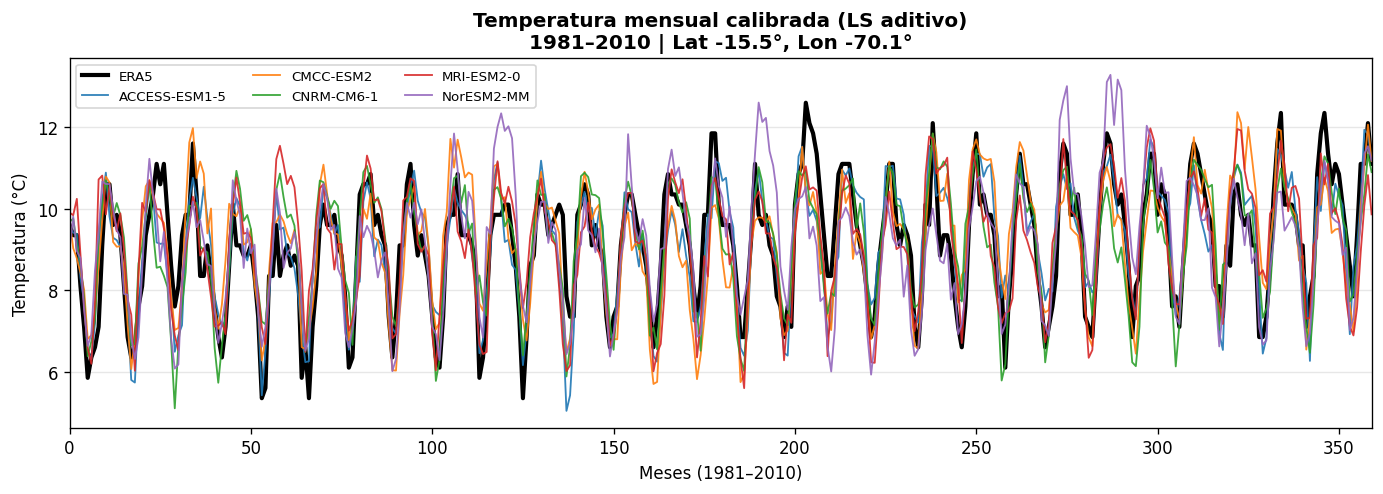

In [20]:
# ============================================================
# SERIE 1981–2010
# Modelo regrillado–calibrado (LS) vs ERA5 (tas)
# ============================================================

plt.figure(figsize=(14, 4))

# ------------------------------------------------------------
# ERA5 (referencia)
# ------------------------------------------------------------
era = (
    tas_era5_dom
    .sel(valid_time=PERIODO_CLIM)
    .sel(latitude=LAT_PTO, longitude=LON_PTO, method="nearest")
    .values
)

x = np.arange(len(era))  # eje X simple (meses)

plt.plot(x, era, "k", lw=2.5, label="ERA5")

# ------------------------------------------------------------
# Modelos calibrados (LS aditivo)
# ------------------------------------------------------------
for modelo, tas_corr in TAS_CORR.items():
    serie = (
        tas_corr
        .sel(valid_time=PERIODO_CLIM)
        .sel(latitude=LAT_PTO, longitude=LON_PTO, method="nearest")
        .values
    )
    plt.plot(x, serie, lw=1.1, alpha=0.9, label=modelo)

# ------------------------------------------------------------
# Etiquetas y formato
# ------------------------------------------------------------
plt.title(
    f"Temperatura mensual calibrada (LS aditivo)\n"
    f"1981–2010 | Lat {LAT_PTO}°, Lon {LON_PTO}°",
    fontweight="bold"
)
plt.ylabel("Temperatura (°C)")
plt.xlabel("Meses (1981–2010)")

plt.legend(ncol=3, fontsize=8)
plt.grid(axis="y", alpha=0.3)
plt.margins(x=0)

plt.show()


In [21]:
# ============================================================
# LECTURA DE ESCENARIOS FUTUROS CMIP6 (tas)
# ROBUSTO PARA CALENDARIOS CFTime (noleap, 365_day)
# ============================================================

import intake
import xarray as xr

# ------------------------------------------------------------
# CATÁLOGO CMIP6
# ------------------------------------------------------------
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)

# ------------------------------------------------------------
# MODELOS Y MIEMBROS
# ------------------------------------------------------------
MODELOS = {
    "ACCESS-ESM1-5": "r1i1p1f1",
    "CMCC-ESM2":     "r1i1p1f1",
    "CNRM-CM6-1":    "r1i1p1f2",
    "MRI-ESM2-0":    "r1i1p1f1",
    "NorESM2-MM":    "r1i1p1f1"
}

# ------------------------------------------------------------
# ESCENARIOS SSP
# ------------------------------------------------------------
SSP_LIST = ["ssp126", "ssp245", "ssp370", "ssp585"]

# ------------------------------------------------------------
# PERIODO FUTURO (por año, NO por string)
# ------------------------------------------------------------
#YEAR_INI = 2036
#YEAR_FIN = 2065

YEAR_INI = 2066
YEAR_FIN = 2095

# ------------------------------------------------------------
# CONTENEDORES
# ------------------------------------------------------------
tas_futuro = {}      # tas_futuro[ssp][modelo]
datasets_futuro = {}

# ------------------------------------------------------------
# BUCLE SSP × MODELO
# ------------------------------------------------------------
for ssp in SSP_LIST:
    print(f"\n==============================")
    print(f"  ESCENARIO {ssp.upper()}")
    print(f"==============================")

    tas_futuro[ssp] = {}

    for modelo, member in MODELOS.items():
        print(f"\nAbriendo {modelo} ({member})...")

        cat_tmp = cat.search(
            activity_id="ScenarioMIP",
            source_id=modelo,
            experiment_id=ssp,
            table_id="Amon",
            variable_id="tas",
            member_id=member
        )

        if len(cat_tmp.df) == 0:
            print(f"  ❌ {modelo}: no disponible para {ssp}")
            continue

        ds = list(
            cat_tmp.to_dataset_dict(
                zarr_kwargs={"consolidated": False},
                storage_options={"token": "anon"},
                xarray_open_kwargs={"use_cftime": True}
            ).values()
        )[0]

        # ----------------------------------------------------
        # Corregir longitudes CMIP6 (0–360 → -180–180)
        # ----------------------------------------------------
        ds = fix_lon_cmip(ds)

        # ----------------------------------------------------
        # Selección temporal FUTURA (ROBUSTA A CFTime)
        # ----------------------------------------------------
        ds = ds.where(
            (ds.time.dt.year >= YEAR_INI) &
            (ds.time.dt.year <= YEAR_FIN),
            drop=True
        )

        if ds.time.size == 0:
            print(f"  ⚠️ {modelo}: sin datos en periodo futuro")
            continue

        # ----------------------------------------------------
        # Conversión tas → °C
        # ----------------------------------------------------
        tas_modelo = ds["tas"] - 273.15
        tas_modelo.attrs["units"] = "°C"
        tas_modelo.attrs["long_name"] = "Temperatura del aire a 2 m"

        tas_futuro[ssp][modelo] = tas_modelo
        datasets_futuro[(ssp, modelo)] = ds

        print(f"  ✅ {modelo} cargado | meses = {tas_modelo.time.size}")



  ESCENARIO SSP126

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ ACCESS-ESM1-5 cargado | meses = 360

Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado | meses = 360

Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/usr/local/lib/python3.12/dist-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 3. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/usr/local/lib/python3.12/dist-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 9. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)


  ✅ CNRM-CM6-1 cargado | meses = 360

Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado | meses = 360

Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado | meses = 360

  ESCENARIO SSP245

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...
  ❌ ACCESS-ESM1-5: no disponible para ssp245

Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado | meses = 360

Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado | meses = 360

Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado | meses = 360

Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado | meses = 360

  ESCENARIO SSP370

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...
  ❌ ACCESS-ESM1-5: no disponible para ssp370

Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado | meses = 360

Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/usr/local/lib/python3.12/dist-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 3. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/usr/local/lib/python3.12/dist-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 9. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)


  ✅ CNRM-CM6-1 cargado | meses = 360

Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/usr/local/lib/python3.12/dist-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 655. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)


  ✅ MRI-ESM2-0 cargado | meses = 360

Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado | meses = 360

  ESCENARIO SSP585

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ ACCESS-ESM1-5 cargado | meses = 360

Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado | meses = 360

Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado | meses = 360

Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado | meses = 360

Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado | meses = 360


In [22]:
# ============================================================
# PASO 1) CMIP6 FUTURO -> GRILLA ERA5 (tas, SSP × modelo)
# ============================================================

def cmip_future_to_era_grid_tas(tas_cmip, era_lat, era_lon, dominio):
    """
    Interpola CMIP6 futuro (tas, time, lat, lon) a la grilla ERA5.
    Devuelve DataArray con dims:
    (valid_time, latitude, longitude)
    """

    # --------------------------------------------------------
    # Selección espacial
    # --------------------------------------------------------
    da = tas_cmip.sel(**dominio)

    # Quitar dimensiones extra (member_id, etc.)
    da = squeeze_cmip_da(da)

    # Asegurar orden correcto
    da = da.sortby("lat").sortby("lon")

    # --------------------------------------------------------
    # Interpolación bilinear (ERA5 define la grilla)
    # --------------------------------------------------------
    da_i = da.interp(lat=era_lat, lon=era_lon, method="linear")

    # Renombrar tiempo
    da_i = da_i.rename({"time": "valid_time"})

    # Asegurar nombres estándar
    if "lat" in da_i.dims:
        da_i = da_i.rename({"lat": "latitude"})
    if "lon" in da_i.dims:
        da_i = da_i.rename({"lon": "longitude"})

    da_i.attrs["units"] = "°C"
    da_i.attrs["long_name"] = "Temperatura del aire a 2 m"

    return da_i


# ------------------------------------------------------------
# REGRILLADO FUTURO SSP × MODELO
# ------------------------------------------------------------
TAS_FUT_ON_ERA = {}   # TAS_FUT_ON_ERA[ssp][modelo]

for ssp in SSP_LIST:
    TAS_FUT_ON_ERA[ssp] = {}

    for modelo, tas_da in tas_futuro[ssp].items():
        print(f"Regrill futuro -> ERA5: {ssp} | {modelo}")

        tas_on_era = cmip_future_to_era_grid_tas(
            tas_da,
            era_lat,
            era_lon,
            DOMINIO_BUF
        )

        TAS_FUT_ON_ERA[ssp][modelo] = tas_on_era

print(
    "✔ Futuro tas regrillado a ERA5 para:",
    {ssp: list(TAS_FUT_ON_ERA[ssp].keys()) for ssp in SSP_LIST}
)


Regrill futuro -> ERA5: ssp126 | ACCESS-ESM1-5
Regrill futuro -> ERA5: ssp126 | CMCC-ESM2
Regrill futuro -> ERA5: ssp126 | CNRM-CM6-1
Regrill futuro -> ERA5: ssp126 | MRI-ESM2-0
Regrill futuro -> ERA5: ssp126 | NorESM2-MM
Regrill futuro -> ERA5: ssp245 | CMCC-ESM2
Regrill futuro -> ERA5: ssp245 | CNRM-CM6-1
Regrill futuro -> ERA5: ssp245 | MRI-ESM2-0
Regrill futuro -> ERA5: ssp245 | NorESM2-MM
Regrill futuro -> ERA5: ssp370 | CMCC-ESM2
Regrill futuro -> ERA5: ssp370 | CNRM-CM6-1
Regrill futuro -> ERA5: ssp370 | MRI-ESM2-0
Regrill futuro -> ERA5: ssp370 | NorESM2-MM
Regrill futuro -> ERA5: ssp585 | ACCESS-ESM1-5
Regrill futuro -> ERA5: ssp585 | CMCC-ESM2
Regrill futuro -> ERA5: ssp585 | CNRM-CM6-1
Regrill futuro -> ERA5: ssp585 | MRI-ESM2-0
Regrill futuro -> ERA5: ssp585 | NorESM2-MM
✔ Futuro tas regrillado a ERA5 para: {'ssp126': ['ACCESS-ESM1-5', 'CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM'], 'ssp245': ['CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM'], 'ssp370': ['CMCC-

In [32]:
# ============================================================
# PASO 2) APLICAR LS AL FUTURO (tas, factor mensual del histórico)
# ============================================================

TAS_FUT_CORR = {}   # TAS_FUT_CORR[ssp][modelo]

for ssp in SSP_LIST:
    TAS_FUT_CORR[ssp] = {}

    for modelo, tas_on_era in TAS_FUT_ON_ERA[ssp].items():

        if modelo not in FACTORES_TAS:
            print(f"⚠️ No hay FACTOR LS para {modelo} (se salta)")
            continue

        # Factor LS aditivo (month, latitude, longitude)
        factor = FACTORES_TAS[modelo]

        # Aplicar corrección (SUMA, no multiplicación)
        tas_corr = tas_on_era.groupby("valid_time.month") + factor
        tas_corr = tas_corr.drop_vars("month", errors="ignore")
        tas_corr.name = "tas_ls_future"

        tas_corr.attrs.update({
            "units": "°C",
            "calibration": "Linear Scaling aditivo vs ERA5 (1981–2010)",
            "model": modelo,
            "scenario": ssp
        })

        TAS_FUT_CORR[ssp][modelo] = tas_corr

print("✔ Futuro (tas) calibrado con LS listo.")


✔ Futuro (tas) calibrado con LS listo.


In [33]:
# ============================================================
# PASO 3) EXTRAER SERIES EN EL PUNTO (LAT_PTO, LON_PTO) – TAS
# ============================================================

def point_series_era_grid(da, lat_pt, lon_pt):
    """Extrae serie temporal en un punto desde DataArray en grilla ERA5."""
    return (
        da.sel(latitude=lat_pt, longitude=lon_pt, method="nearest")
          .squeeze()
    )

# ------------------------------------------------------------
# Histórico calibrado (LS aditivo)
# ------------------------------------------------------------
SER_HIST_TAS_CORR = {}

for modelo, tas_corr in TAS_CORR.items():
    SER_HIST_TAS_CORR[modelo] = point_series_era_grid(
        tas_corr, LAT_PTO, LON_PTO
    )

# ------------------------------------------------------------
# Futuro calibrado (LS aditivo)
# ------------------------------------------------------------
SER_FUT_TAS_CORR = {}   # SER_FUT_TAS_CORR[ssp][modelo]

for ssp in SSP_LIST:
    SER_FUT_TAS_CORR[ssp] = {}

    for modelo, tas_corr_fut in TAS_FUT_CORR[ssp].items():
        SER_FUT_TAS_CORR[ssp][modelo] = point_series_era_grid(
            tas_corr_fut, LAT_PTO, LON_PTO
        )

print("✔ Series de temperatura (tas) en punto listas.")

✔ Series de temperatura (tas) en punto listas.


In [34]:
# ============================================================
# PASO 4) CICLO ANUAL (12 meses) y COMPARACIÓN – TAS
# (ROBUSTO PARA CALENDARIOS CFTime)
# ============================================================

def annual_cycle(serie, time_name="valid_time"):
    """Devuelve climatología mensual (1..12)."""
    return serie.groupby(f"{time_name}.month").mean(time_name, skipna=True)


# ------------------------------------------------------------
# Histórico (1981–2010): ciclo anual por modelo
# ------------------------------------------------------------
AC_HIST_TAS = {}

for modelo, ser in SER_HIST_TAS_CORR.items():

    tname = (
        "valid_time" if "valid_time" in ser.dims
        else ("time" if "time" in ser.dims else None)
    )
    if tname is None:
        raise ValueError(f"Dimensión tiempo no reconocida en HIST {modelo}")

    # 🔹 filtro robusto por año
    ser_sub = ser.where(
        (ser[tname].dt.year >= 1981) &
        (ser[tname].dt.year <= 2010),
        drop=True
    )

    AC_HIST_TAS[modelo] = annual_cycle(ser_sub, time_name=tname)


# ------------------------------------------------------------
# Futuro (2036–2065): ciclo anual por SSP y modelo
# ------------------------------------------------------------
AC_FUT_TAS = {}

for ssp in SSP_LIST:
    AC_FUT_TAS[ssp] = {}

    for modelo, ser in SER_FUT_TAS_CORR[ssp].items():

        tname = (
            "valid_time" if "valid_time" in ser.dims
            else ("time" if "time" in ser.dims else None)
        )
        if tname is None:
            raise ValueError(f"Dimensión tiempo no reconocida en FUT {ssp}-{modelo}")

        # 🔹 filtro robusto por año (CLAVE)
        ser_sub = ser.where(
            #1ER PERIODO FUTURO
            #(ser[tname].dt.year >= 2036) &
            #(ser[tname].dt.year <= 2065),
            #2DO PERIDO FUTURO
            (ser[tname].dt.year >= 2066) &
            (ser[tname].dt.year <= 2095),
            drop=True
        )

        AC_FUT_TAS[ssp][modelo] = annual_cycle(ser_sub, time_name=tname)

print("✔ Ciclos anuales de temperatura (tas) calculados correctamente.")

✔ Ciclos anuales de temperatura (tas) calculados correctamente.


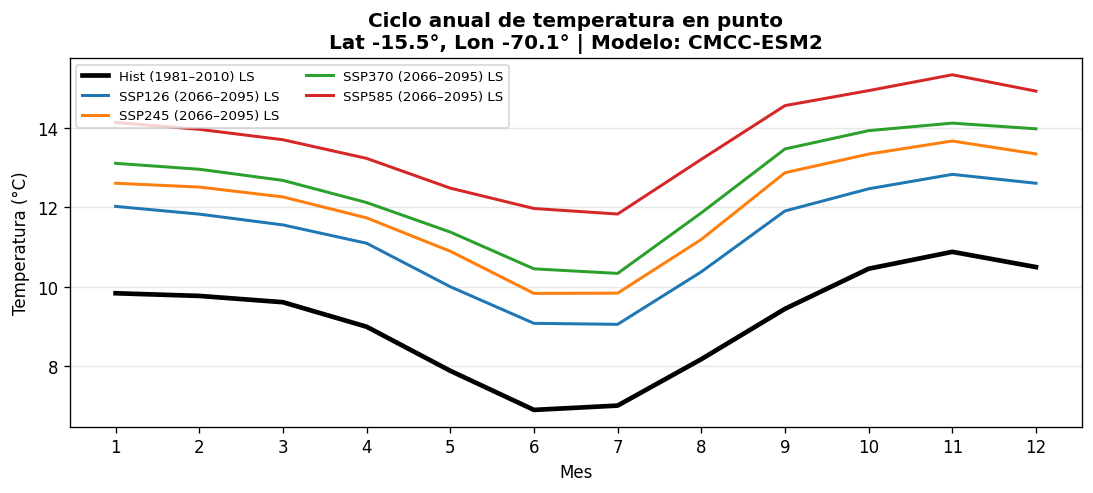

In [35]:
# ============================================================
# PLOT: CICLO ANUAL HIST vs SSPs (tas, para un modelo)
# ============================================================

modelo_plot = "CMCC-ESM2"
meses = np.arange(1, 13)

plt.figure(figsize=(9, 4), constrained_layout=True)

# ------------------------------------------------------------
# Histórico calibrado (LS aditivo)
# ------------------------------------------------------------
plt.plot(
    meses,
    AC_HIST_TAS[modelo_plot].values,
    lw=2.8,
    color="black",
    label="Hist (1981–2010) LS"
)

# ------------------------------------------------------------
# Futuros calibrados (LS aditivo)
# ------------------------------------------------------------
for ssp in SSP_LIST:
    if modelo_plot in AC_FUT_TAS[ssp]:
        plt.plot(
            meses,
            AC_FUT_TAS[ssp][modelo_plot].values,
            lw=1.8,
            #label=f"{ssp.upper()} (2036–2065) LS"
            label=f"{ssp.upper()} (2066–2095) LS"
        )

# ------------------------------------------------------------
# Etiquetas y formato
# ------------------------------------------------------------
plt.xticks(meses)
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.title(
    f"Ciclo anual de temperatura en punto\n"
    f"Lat {LAT_PTO}°, Lon {LON_PTO}° | Modelo: {modelo_plot}",
    fontweight="bold"
)
plt.grid(axis="y", alpha=0.3)
plt.legend(ncol=2, fontsize=8)

plt.show()


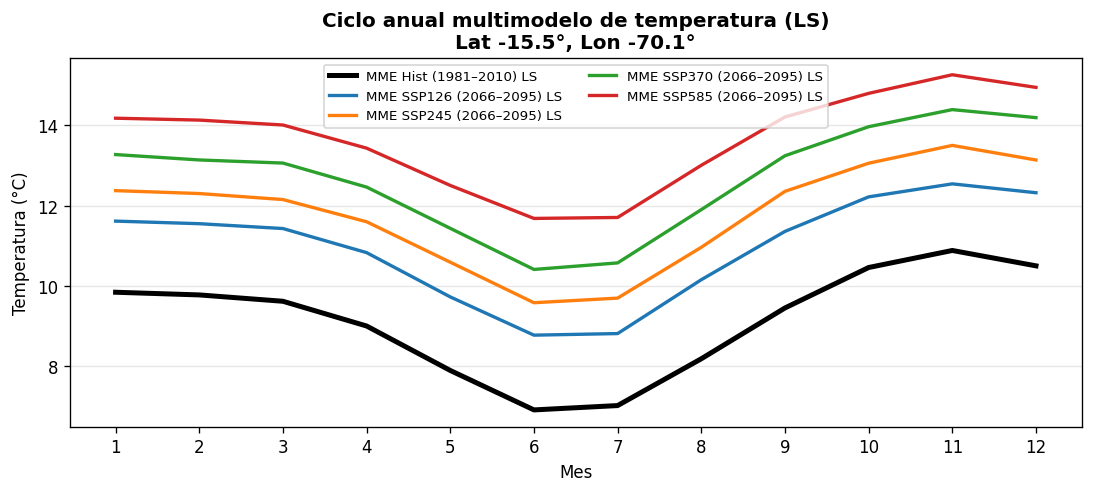

In [36]:
# ============================================================
# EXTRA: MULTIMODELO (ciclo anual) – TAS (5 MODELOS)
# ============================================================

def mean_annual_cycle(dic_ac):
    """Promedia ciclos anuales (dict modelo -> AC[month])."""
    arr = xr.concat(list(dic_ac.values()), dim="model").mean("model", skipna=True)
    return arr

# ------------------------------------------------------------
# Histórico multimodelo
# ------------------------------------------------------------
AC_HIST_TAS_MME = mean_annual_cycle(AC_HIST_TAS)

# ------------------------------------------------------------
# Futuro multimodelo por SSP
# ------------------------------------------------------------
AC_FUT_TAS_MME = {}

for ssp in SSP_LIST:
    if len(AC_FUT_TAS[ssp]) > 0:
        AC_FUT_TAS_MME[ssp] = mean_annual_cycle(AC_FUT_TAS[ssp])

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------
meses = np.arange(1, 13)

plt.figure(figsize=(9, 4), constrained_layout=True)

# Histórico
plt.plot(
    meses,
    AC_HIST_TAS_MME.values,
    lw=3.0,
    color="black",
    label="MME Hist (1981–2010) LS"
)

# Futuros
for ssp in SSP_LIST:
    if ssp in AC_FUT_TAS_MME:
        plt.plot(
            meses,
            AC_FUT_TAS_MME[ssp].values,
            lw=2.0,
            #label=f"MME {ssp.upper()} (2036–2065) LS"
            label=f"MME {ssp.upper()} (2066–2095) LS"
        )

# Etiquetas
plt.xticks(meses)
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.title(
    f"Ciclo anual multimodelo de temperatura (LS)\n"
    f"Lat {LAT_PTO}°, Lon {LON_PTO}°",
    fontweight="bold"
)
plt.grid(axis="y", alpha=0.3)
plt.legend(ncol=2, fontsize=8)

plt.show()


In [41]:
def sel_period_cftime(da, y0, y1, time_name="valid_time"):
    """Selección temporal robusta para ejes cftime."""
    return da.where(
        (da[time_name].dt.year >= y0) &
        (da[time_name].dt.year <= y1),
        drop=True
    )

# Histórico calibrado
CLIM_HIST_ANUAL_TAS = {
    m: sel_period_cftime(TAS_CORR[m], 1981, 2010)
        .mean("valid_time", skipna=True)
    for m in TAS_CORR
}

# Futuro calibrado
CLIM_FUT_ANUAL_TAS = {}
for ssp in SSP_LIST:
    CLIM_FUT_ANUAL_TAS[ssp] = {
        #m: sel_period_cftime(TAS_FUT_CORR[ssp][m], 2036, 2065)
        #    .mean("valid_time", skipna=True)
        m: sel_period_cftime(TAS_FUT_CORR[ssp][m], 2066, 2095)
            .mean("valid_time", skipna=True)
        for m in TAS_FUT_CORR[ssp]
    }

print("✔ Climatologías anuales TAS listas")


✔ Climatologías anuales TAS listas


In [42]:
def multimodel_mean(dic):
    """Promedio multimodelo."""
    return xr.concat(list(dic.values()), dim="model").mean("model", skipna=True)

# MME histórico
MME_HIST_TAS = multimodel_mean(CLIM_HIST_ANUAL_TAS)

# MME futuro por SSP
MME_FUT_TAS = {}
for ssp in SSP_LIST:
    if len(CLIM_FUT_ANUAL_TAS[ssp]) > 0:
        MME_FUT_TAS[ssp] = multimodel_mean(CLIM_FUT_ANUAL_TAS[ssp])

print("✔ MME histórico y futuro calculados")


✔ MME histórico y futuro calculados


In [43]:
DELTA_TAS = {}

for ssp in MME_FUT_TAS:
    delta = MME_FUT_TAS[ssp] - MME_HIST_TAS
    delta.name = f"delta_tas_{ssp}"
    delta.attrs["units"] = "°C"
    delta.attrs["description"] = "Cambio climático de temperatura media anual"
    delta.attrs["period"] = "2036–2065 vs 1981–2010"
    DELTA_TAS[ssp] = delta

print("✔ ΔT calculado para SSPs:", list(DELTA_TAS.keys()))


✔ ΔT calculado para SSPs: ['ssp126', 'ssp245', 'ssp370', 'ssp585']


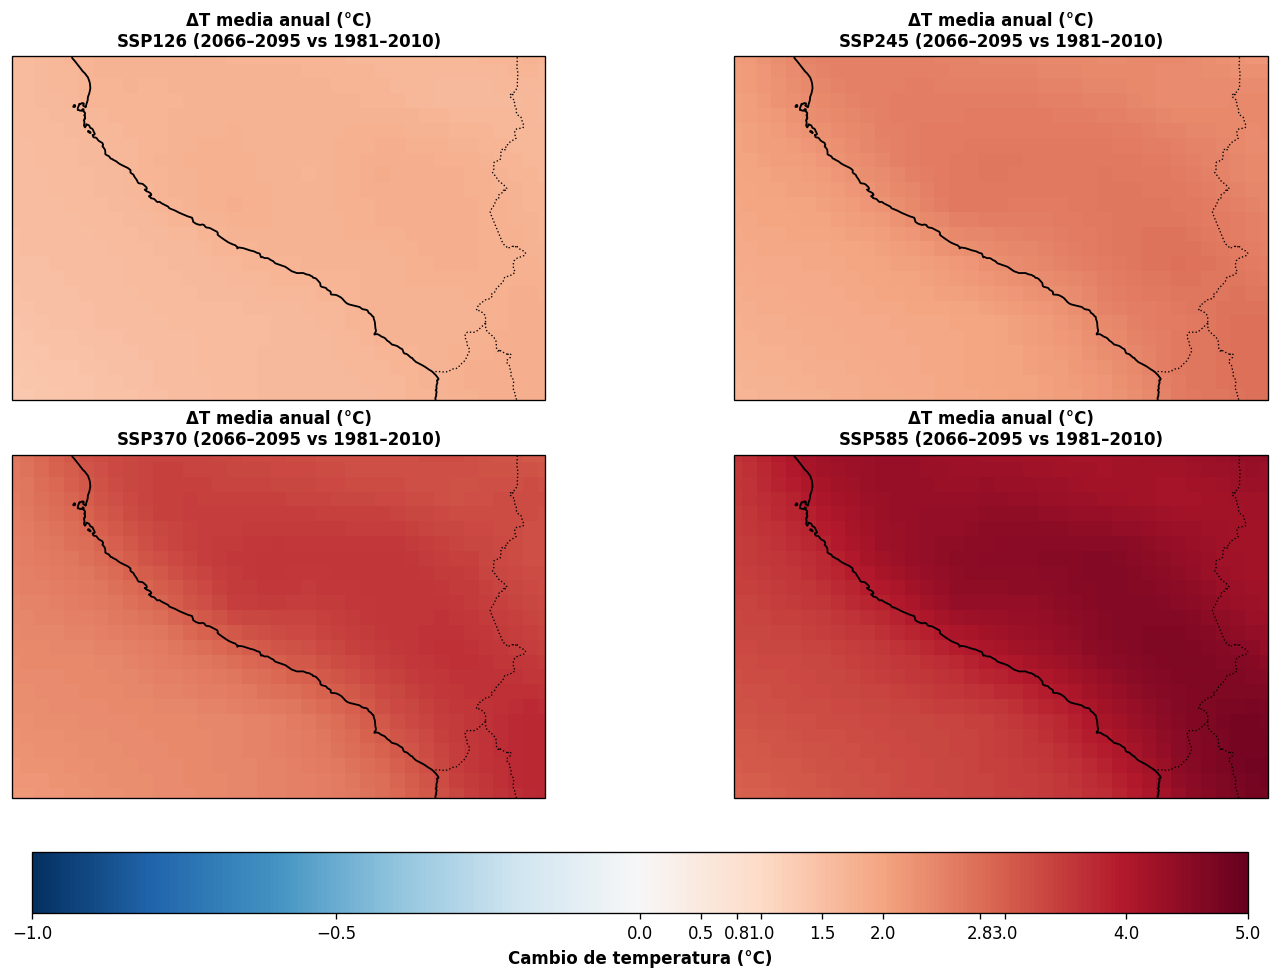

In [45]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

# ============================================================
# CONFIGURACIÓN GENERAL
# ============================================================

proj = ccrs.PlateCarree()

# Dominio final (sin buffer)
extent = [
    DOMINIO["lon"].start, DOMINIO["lon"].stop,
    DOMINIO["lat"].start, DOMINIO["lat"].stop,
]

# Normalización centrada en 0
norm = TwoSlopeNorm(
    vmin=-1.0,
    vcenter=0.0,
    vmax=5.0
)

# Ticks personalizados (°C)
#ticks = [-1, -0.5, 0, 0.5, 0.8, 1, 1.5, 1.8, 2, 2.5, 2.8, 3]
ticks = [-1, -0.5, 0, 0.5, 0.8, 1, 1.5, 2, 2.8, 3, 4, 5]

# Colormap recomendado para ΔT
cmap = "RdBu_r"

# ============================================================
# FIGURA MULTIPANEL (SSPs)
# ============================================================

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12, 8),
    subplot_kw={"projection": proj},
    constrained_layout=True
)

axes = axes.flatten()

# ============================================================
# LOOP POR ESCENARIO
# ============================================================

for ax, ssp in zip(axes, SSP_LIST):

    if ssp not in DELTA_TAS:
        ax.axis("off")
        continue

    da = DELTA_TAS[ssp]

    # Mapa base
    ax.set_extent(extent, crs=proj)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.8)

    # Campo ΔT
    im = ax.pcolormesh(
        da.longitude,
        da.latitude,
        da.values,
        cmap=cmap,
        norm=norm,
        shading="auto",
        transform=proj
    )

    ax.set_title(
        #f"ΔT media anual (°C)\n{ssp.upper()} (2036–2065 vs 1981–2010)",
        f"ΔT media anual (°C)\n{ssp.upper()} (2066–2095 vs 1981–2010)",
        fontweight="bold",
        fontsize=10
    )

# ============================================================
# BARRA DE COLORES COMÚN
# ============================================================

cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="horizontal",
    shrink=0.85,
    pad=0.06,
    ticks=ticks
)

cbar.set_label("Cambio de temperatura (°C)", fontweight="bold")

plt.show()
